In [1]:
import sys
import os
import numpy as np
from scipy.special import hankel2
from typing import List, Tuple

import matplotlib.pyplot as plt

from examples.seismic import RickerSource, Receiver, GaborSource
from devito import Operator, TimeFunction

# add cli to path to load modules
sys.path.insert(0, os.path.abspath("../cli"))
from simulation.sonar import Sonar_v2
from simulation.sources import SineSource

In [2]:
# Switch to error logging so that info is printed but runtime is hidden
from devito import configuration
configuration['log-level'] = 'ERROR'

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Water velocity in km/s
c0 = 1.5 # km/s
# Source peak frequency in KHz
f0 = 50.0
t0_sine = 0.5 / f0 # shift to zero lag

signal_width_ms = 8.0 / f0

# some information about the signal:
signal_width_m = signal_width_ms * c0

n_rec = 10
receiver_distance_m = 10.5
rec_distance_m = np.linspace(0.5, receiver_distance_m, n_rec)
receiver_angle_deg = 45

# Domain size
source_border_distance_m = 2 * signal_width_m + receiver_distance_m
domain_size_m = (2*source_border_distance_m, 2*source_border_distance_m) #m
spatial_res_m = c0 / (3*f0) #m

vp = c0 * np.ones(
    (
        round(domain_size_m[0] / spatial_res_m),
        round(domain_size_m[1] / spatial_res_m),
    ),
    dtype=np.float64,
)

# Simulation end time
tn_ms = 2*source_border_distance_m / c0 # ms

In [4]:
sonar_model = Sonar_v2(
    domain_size=domain_size_m,
    f_critical=f0,
    v_water=c0,
    velocity_profile=vp,
    tn=tn_ms,
    spatial_dist=spatial_res_m
)
model = sonar_model.model
dt_ms = model.critical_dt
print(dt_ms)

0.004082


The computational Grid has (2216, 2216) grid points and a physical extent of (22.150000000000002m, 22.150000000000002m)
Source is at the center with coordinates (10.98m, 10.98m)
Receiver (single receiver) is located at (11.333553390593273m, 11.333553390593273m) 


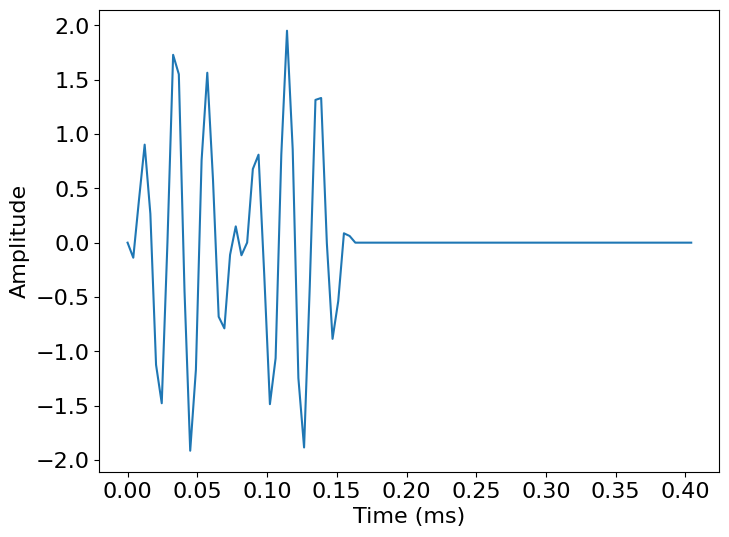

In [5]:
# Source and receiver geometries
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = source_border_distance_m
#model = sonar_model

# Single receiver offset 100 m from source
rec_coordinates = np.empty((n_rec, 2))
for i, r_d_m in enumerate(rec_distance_m):
    rec_coordinates[i, 0] = source_border_distance_m + r_d_m * np.sin(
        np.deg2rad(receiver_angle_deg)
    )
    rec_coordinates[i, 1] = source_border_distance_m + r_d_m * np.cos(
        np.deg2rad(receiver_angle_deg)
    )

print("The computational Grid has (%s, %s) grid points "
       "and a physical extent of (%sm, %sm)" % (*model.grid.shape, *model.grid.extent))
print("Source is at the center with coordinates (%sm, %sm)" % tuple(src_coordinates[0]))
print(
    "Receiver (single receiver) is located at (%sm, %sm) " % tuple(rec_coordinates[0])
)
    
src = SineSource(
    name="src",
    grid=model.grid,
    npoint=1,
    f0=f0,
    time_range=sonar_model.time_range,
    coordinates_data=src_coordinates,
    t0=t0_sine,
    )

rec = Receiver(
    name="rec",
    grid=model.grid,
    time_range=sonar_model.time_range,
    npoint=n_rec,
    coordinates=rec_coordinates,
)
sonar_model.set_source(src, rec)
sonar_model.finalize(space_order=4)

plt.figure()
plt.plot(src.time_values[0:100], src.data[:100,0])
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()

# Reference solution for numerical convergence

In [6]:
assert isinstance(sonar_model.op, Operator) and isinstance(sonar_model.rec, Receiver)
sonar_model.op(time=sonar_model.time_range.num - 2, dt=sonar_model.model.critical_dt)

assert isinstance(sonar_model.u, TimeFunction)
ref_rec = sonar_model.rec
ref_u = sonar_model.u

In [7]:
# Define a Ricker wavelet shifted to zero lag for the Fourier transform
def ricker(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    tt = (np.pi**2) * (f**2) * (t**2)
    y = (1.0 - 2.0 * tt) * np.exp(- tt)
    return y

def sinewave(f, T, dt, t0):
    t = np.linspace(-t0, T-t0, int(T/dt))
    r = 2 * np.pi * f * t
    y = np.sin(r) + np.sin(3 * (r + np.pi) / 4)
    y[np.searchsorted(t, 4 * 2 / f) :] = 0
    return y

def analytical_dist(dist_m: float, time: List[float], dx: float, wavelet):
    nt = len(time)
    nf = int(nt/2 + 1)
    df = 1.0 / time[-1]
    faxis = df * np.arange(nf)
    # Take the Fourier transform of the source time-function
    R = np.fft.fft(wavelet)
    R = R[0:nf]
    nf = len(R)

    # Compute the Hankel function and multiply by the source spectrum
    U_a = np.zeros((nf), dtype=complex)
    for a in range(1, nf-1):
        k = 2 * np.pi * faxis[a] / c0
        tmp = k * dist_m
        U_a[a] = -1j * np.pi * hankel2(0.0, tmp) * R[a]

    # Do inverse fft on 0:dt:T and you have analytical solution
    U_t = 1.0/(2.0 * np.pi) * np.real(np.fft.ifft(U_a[:], nt))
    
    # The analytic solution needs be scaled by dx^2 to convert to pressure
    return np.real(U_t) * (dx**2)

def analytical_from_pos(
    src_pos: Tuple[float, float],
    rec_pos: Tuple[float, float],
    time: List[float],
    dx: float,
    wavelet,
):
    analytical_dist(
        np.sqrt(((rec_pos[0] - src_pos[0])) ** 2 + ((rec_pos[1] - src_pos[1])) ** 2),
        time,
        dx,
        wavelet,
    )

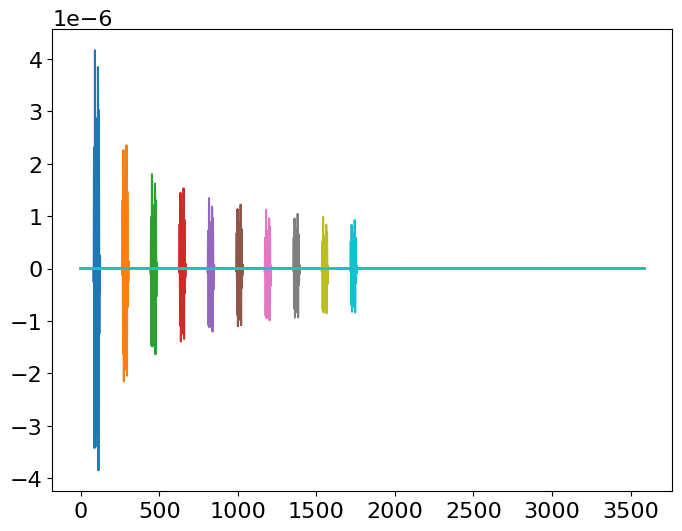

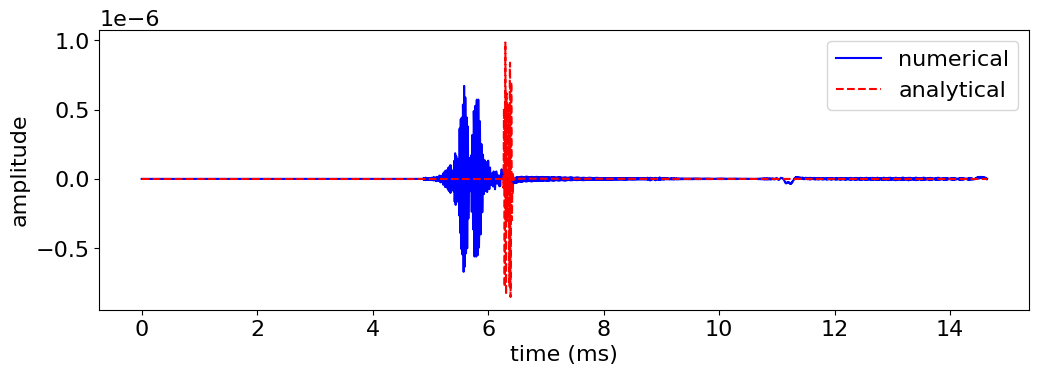

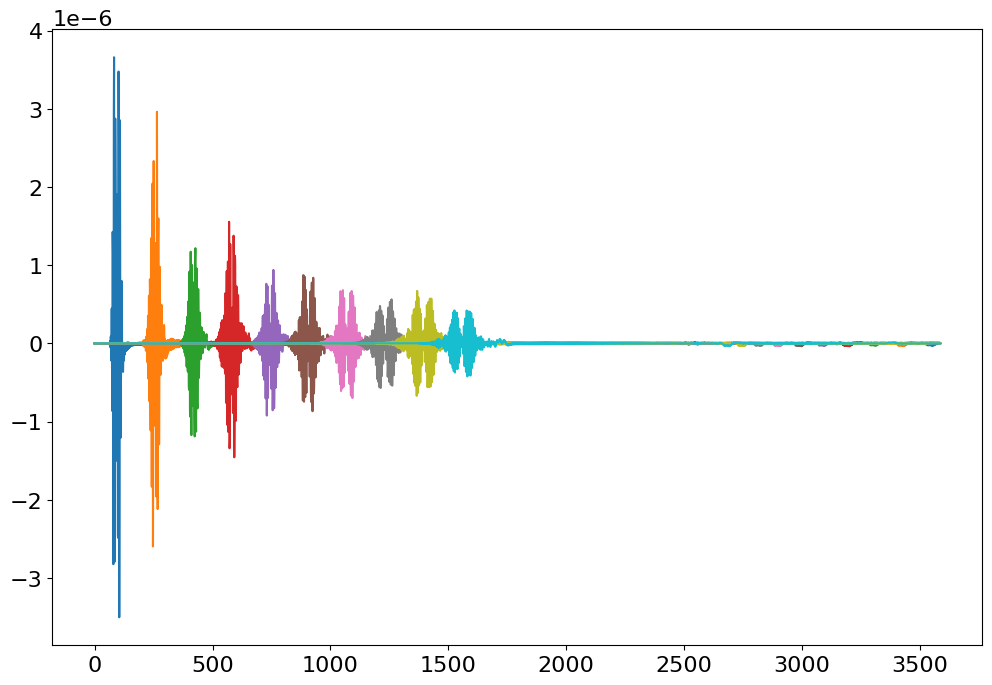

In [9]:
#%matplotlib widget
wavelet = sinewave(f0, tn_ms, dt_ms, t0_sine)

signal_dist_m = np.linspace(0.5, 10.5, 10)
responses = np.zeros((len(signal_dist_m), int(tn_ms/dt_ms)+2))

for i, dist_m in enumerate(signal_dist_m):
    responses[i, :] = analytical_dist(
        dist_m, sonar_model.time_range.time_values, spatial_res_m, wavelet
    )

plt.plot(responses.T)

# Plot trace
time = sonar_model.time_range.time_values
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(time, ref_rec.data[:, 8], '-b', label='numerical')
plt.plot(time, responses[8,:], '--r', label='analytical')
#plt.xlim([1,2])
# plt.ylim([1.15*np.min(U_t[:]), 1.15*np.max(U_t[:])])
plt.xlabel('time (ms)')
plt.ylabel('amplitude')
plt.legend()
# plt.subplot(2,1,2)
# plt.plot(time, 100 *(ref_rec.data[:, 0] - U_t[:]), '-b', label='difference x100')
# plt.xlim([0,300])
# plt.ylim([1.15*np.min(U_t[:]), 1.15*np.max(U_t[:])])
# plt.xlabel('time (ms)')
# plt.ylabel('amplitude x100')
# plt.legend()
# plt.savefig('ref.pdf')

plt.figure(figsize=(12,8))
rec = np.array(ref_rec.data)
plt.plot(rec)
plt.show()